# Energy Packet Initialization

## Theory

While it is instructive to think about tracking the propagation history of
individual photons when illustrating the basic idea behind Monte Carlo radiative transfer
techniques, there are important numerical reasons for using a different
discretization scheme. Instead of thinking in the photon picture, it brings
significant advantages to follow the idea of <strong data-cite="Abbott1985">[]</strong> and
<strong data-cite="Lucy1999">[]</strong> and consider parcels of radiant energy as the fundamental
building blocks of the Monte Carlo calculation. These basic Monte Carlo quanta
are commonly referred to as "energy packets" or simply "packets", and are composed of many photons with the same frequency.

During a Monte Carlo calculation, $N$ (a large number) packets, all with a certain
energy $\varepsilon$, are created at the inner boundary of the computational domain (which is discussed in the [model section](../setup/model.rst)) known as the photosphere. Currently, the photosphere is modeled as a spherical [blackbody](https://en.wikipedia.org/wiki/Black-body_radiation) with a radius $r_\mathrm{boundary\_inner}$ and temperature $T_\mathrm{inner}$. Both of these quantities are calculated as a part of the [model](../setup/model.ipynb), and $T_\mathrm{inner}$ is additionally updated throughout the simulation as a part of the [Updating Plasma and Convergence](../update_and_conv/update_and_conv.ipynb) process.

In TARDIS, all packets are assigned identical energies **in the lab frame** (see [Reference Frames](propagation.rst#reference-frames)), and the total (lab-frame) energy of the packets is 1 erg (and thus each packet has an energy of $\frac{1}{N}$ ergs).

<div class="alert alert-info">
    
Note

The indivisible energy packet scheme does not require that all packets have the same energy. This is just a convenient and simple choice adopted in TARDIS.

</div>

<div class="alert alert-info">
    
Note

Since all packets have the same total, and photon energy is proportional to frequency, higher-frequency packets will represent less real photons than lower-frequency packets.

</div>

Since the photosphere is modeled as a blackbody, its total luminosity $L_\mathrm{inner}$ (recall that luminosity is energy emitted divided by the time in which it is emitted) is
$$L_\mathrm{inner}=\frac{N\varepsilon}{\Delta t}=4 \pi r_\mathrm{boundary\_inner}^2 \sigma_{\mathrm{R}} T_{\mathrm{inner}}^4$$
where $\sigma_\mathrm{R}$ is the Stefan-Boltzmann constant and $\Delta t$ is the physical duration of the simulation. In order to make this relationship hold (remembering that $N\varepsilon = 1$ erg), we use
$$\Delta t = \frac{1}{L_\mathrm{inner}}=\frac{1}{4 \pi r_\mathrm{boundary\_inner}^2 \sigma_{\mathrm{R}} T_{\mathrm{inner}}^4}.$$

<div class="alert alert-info">
    
Note

As will be shown in the code example, this will lead to unphysically small values for $\Delta t$. It may be easier to think of the Monte Carlo packets not as packets of energy $\epsilon$ going through a simulation of duration $\Delta t$, but as packets of luminosity that carry an energy $\epsilon$ over a time $\Delta t$ (and thus truly being luminosity packets of luminosity $\frac{\epsilon}{\Delta t}$). Indeed, this view of the packets will be useful when deriving the [Monte Carlo Estimators](estimators.rst).

</div>

During packet initialization, each packet is assigned an initial propagation direction $\mu$ which is the cosine of the angle $\theta$ which the packet's path makes with the radial direction (see the image below). Using a pseudo-random number generator which generates numbers $z$ uniformly distributed on the interval $[0,1]$, the propagation direction is determined (due to physical considerations beyond the scope of this documentation) according to
$$\mu = \sqrt{z}.$$
This sampling is shown in the "Code Example" section.

<img src="../images/propagation_direction.png" width=500>

Finally, each packet is assigned an initial frequency (or more precisely, the initial frequency of its constituent photons). Note that since each packet has the same energy, each packet will represent a different number of real photons. The sampling on packet frequencies is more involved than that of the propagation direction, as it involves sampling the Planck distribution (see below). TARDIS uses the technique described in <strong data-cite="Carter1975">[]</strong> and summarized in <strong data-cite="Bjorkman2001">[]</strong> for this purpose.

During the simulation, the energy of the packet remains constant in the local
co-moving frame (see [Reference Frames](propagation.rst#reference-frames)). This naturally ensures energy
conservation and constitutes the main advantage of this discretization scheme. **However, while the energy of the packets is conserved in the co-moving frame, the co-moving frequency of the packet (and thus the photons represented by the packet) may vary over the course of the simulation. Thus, a packet may represent several different numbers of real photons throughout their lifetimes.**

## Code Example

We now demonstrate the TARDIS packet initialization framework:

In [1]:
import numpy as np
from tardis.montecarlo.packet_source import BlackBodySimpleSource
from astropy import units as u
from tardis import constants as const
import matplotlib.pyplot as plt
import numba
import time
import pandas as pd
import itertools
import tqdm.auto as tqdm
import scipy.stats as stats


# The random number generator that will be used
rng = np.random.default_rng()

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

The following cell contains values that you can change to see how it affects the spectrum (in an actual simulation, the seed and number of packets are set in the [Monte Carlo configuration](../../io/configuration/components/montecarlo.rst), and the photospheric radius is calculated as a part of the [model](../setup/model.ipynb)):

In [2]:
# Seed for the pseudo-random number generator
seed = 1

# Number of packets generated
n_packets = 40000

# Radius of the supernova's photosphere in cm
r_boundary_inner = 1e15 * u.cm

We set the temperature of the photosphere $T_\mathrm{inner}$, which will determine the photospheric luminosity (in an actual simulation, $T_\mathrm{inner}$ is initially calculated as a part of the [model](../setup/model.ipynb) and updated as a part of the [Updating Plasma and Convergence](../update_and_conv/update_and_conv.ipynb) process):

In [3]:
# Temperature in K
temperature_inner = 10000 * u.K

luminosity_inner = (
    4
    * np.pi
    * (r_boundary_inner**2)
    * const.sigma_sb
    * (temperature_inner**4)
)

# Makes sure the luminosity is given in erg/s
luminosity_inner = luminosity_inner.to("erg/s")

print(
    "Luminosity of photosphere:",
    luminosity_inner,
)

Luminosity of photosphere: 7.125600863965567e+42 erg / s


We now generate the ensemble of packets. The array of packet energies and radii are also shown.

In [4]:
# We define our packet source
packet_source = BlackBodySimpleSource(seed)

radii, nus, mus, energies = packet_source.create_packets(
    temperature_inner.value,
    n_packets,
    rng,
    r_boundary_inner,
)

# Sets the energies in units of ergs
energies *= u.erg

# Sets the frequencies in units of Hz
nus *= u.Hz

print(
    "Energies:",
    energies,
)
print(
    "Radii:",
    radii,
)

Energies: [2.5e-05 2.5e-05 2.5e-05 ... 2.5e-05 2.5e-05 2.5e-05] erg
Radii: [1.e+15 1.e+15 1.e+15 ... 1.e+15 1.e+15 1.e+15] cm


We set the timespan of the simulation so that each packet contributes the appropriate luminosity to the spectrum.

In [5]:
# Time of simulation
t_simulation = 1 * u.erg / luminosity_inner
print(
    "Time of simulation:",
    t_simulation,
)

# Array of luminosity contribution by each packet
lumin_per_packet = energies / t_simulation
print(
    "Luminosity per packet:",
    lumin_per_packet,
)

Time of simulation: 1.4033904215110305e-43 s
Luminosity per packet: [1.78140022e+38 1.78140022e+38 1.78140022e+38 ... 1.78140022e+38
 1.78140022e+38 1.78140022e+38] erg / s


We define important constants, and for comparison's sake, we code the Planck distribution function
$$L_\nu (\nu)=\frac{8\pi r_\mathrm{boundary\_inner}^2 h\nu^3}{c^2}\frac{1}{\exp\left(\frac{h\nu}{k_BT_\mathrm{inner}}\right)-1}$$
where $L_\nu$ is the luminosity density (see [Basic Spectrum Generation](../spectrum/basic.ipynb)) with respect to frequency, $\nu$ is frequency, $h$ is Planck's constant, $c$ is the speed of light, and $k_B$ is Boltzmann's constant:

In [6]:
h = const.h.cgs
c2 = const.c.cgs**2
kB = const.k_B.cgs


def planck_function(nu):
    return (
        8
        * np.pi**2
        * r_boundary_inner**2
        * h
        * nu**3
        / (c2 * (np.exp(h * nu / (kB * temperature_inner)) - 1))
    )

We plot the Planck distribution and a histogram of the generated packet distribution:

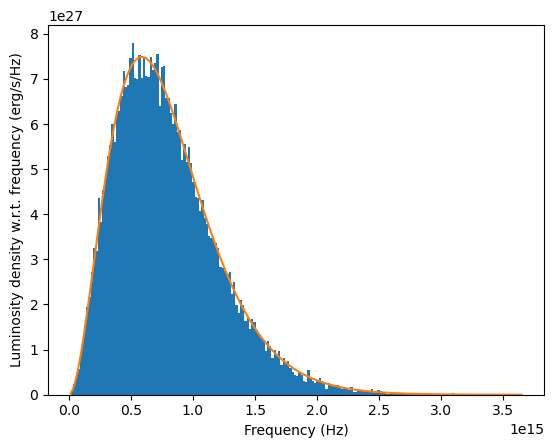

In [7]:
# We set important quantites for making our histogram
bins = 200
nus_planck = np.linspace(
    min(nus),
    max(nus),
    bins,
)
bin_width = nus_planck[1] - nus_planck[0]

# In the histogram plot below, the weights argument is used
# to make sure our plotted spectrum has the correct y-axis scale
plt.hist(
    nus.value,
    bins=bins,
    weights=lumin_per_packet / bin_width,
)

# We plot the planck function for comparison
# plt.plot(nus_planck, planck_function(nus_planck))
plt.plot(
    nus_planck,
    planck_function(nus_planck),
)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Luminosity density w.r.t. frequency (erg/s/Hz)")
plt.show()

We finally plot the generated $\mu$ density distribution, followed by the generated $\theta=\arccos (\mu)$ density distribution, compared with the respective curves $\rho = 2\mu$ and $\rho = \sin(2\theta)$:

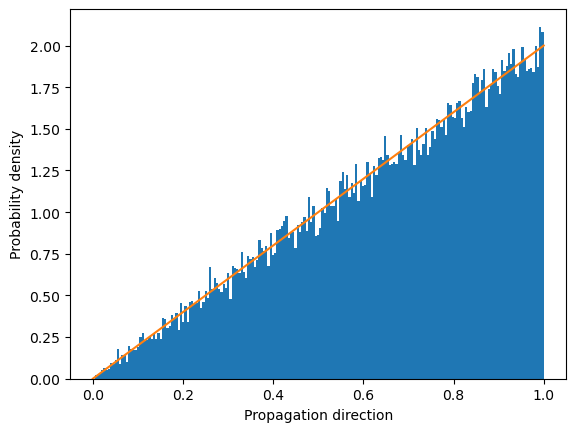

In [8]:
x = np.linspace(0, 1, 1000)

plt.hist(
    mus,
    bins=bins,
    density=True,
)
plt.plot(
    x,
    2 * x,
)
plt.xlabel("Propagation direction")
plt.ylabel("Probability density")
plt.show()

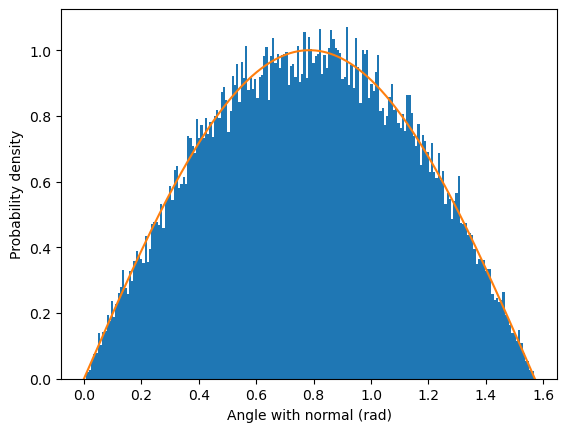

In [9]:
thetas = np.linspace(
    0,
    np.pi / 2,
    1000,
)

plt.hist(
    np.arccos(mus),
    bins=bins,
    density=True,
)
plt.plot(
    thetas,
    np.sin(2 * thetas),
)
plt.xlabel("Angle with normal (rad)")
plt.ylabel("Probability density")
plt.show()

## Custom Packet Source

TARDIS allows for the user to input a custom function that generates energy packets instead of the basic blackbody source described here. See [Running TARDIS with a Custom Packet Source](../../io/optional/custom_source.ipynb) for more information.

## Numba Implementation of Planck Function

The remaining objective is to implement ```planck_function()``` using Numba and compare results to the non-Numba implementation. It is unclear a priori how many simulations should be run to give an accurate idea of what the average is. Here, the number of iterations for each time trial is chosen according to the process described in [section 1.3.2 of these notes](http://www.mit.edu/~kircher/sim.pdf#section.1.3). Plots of execution times are also included.

In [10]:
@numba.njit()
def planck_function_numba(nu):
    return (
        8
        * np.pi**2
        * r_boundary_inner**2
        * h
        * nu**3
        / (c2 * (np.exp(h * nu / (kB * temperature_inner)) - 1))
    )


@numba.njit(parallel=True)
def planck_function_numba_parallel(nu):
    return (
        8
        * np.pi**2
        * r_boundary_inner**2
        * h
        * nu**3
        / (c2 * (np.exp(h * nu / (kB * temperature_inner)) - 1))
    )


_ = planck_function_numba(nus_planck)  # Force Numba compilation
_ = planck_function_numba_parallel(nus_planck)  # Force Numba compilation

### Initial Pass of Time Trials

Below is the first naive pass of simulations that will be used to calculate the number of remaining needed trials.

In [11]:
freq_bins = tuple(
    itertools.chain.from_iterable(
        ((1 * 10**e, 2 * 10**e, 5 * 10**e) for e in range(2, 7))
    )
)
# The prompt only asked for 100, 200, and 500, but seeing how performance
# grows for more frequency bins can possibly be informative.

function_names = (
    "planck_function",
    "planck_function_numba",
    "planck_function_numba_parallel",
)

functions = (
    planck_function,
    planck_function_numba,
    planck_function_numba_parallel,
)

funcdict = {
    funcname: func for (funcname, func) in zip(function_names, functions)
}

N_initial = 50

raw_time_data_columns = (
    "func_name",
    "freq_bins",
    "exec_time",
    "date",
)
raw_time_data = pd.DataFrame(columns=raw_time_data_columns)
raw_time_data[raw_time_data_columns[0]] = raw_time_data[
    raw_time_data_columns[0]
].astype("category")
raw_time_data[raw_time_data_columns[1]] = pd.to_numeric(
    raw_time_data[raw_time_data_columns[1]], downcast="integer"
)
raw_time_data[raw_time_data_columns[2]] = pd.to_numeric(
    raw_time_data[raw_time_data_columns[2]], downcast="integer"
)
raw_time_data[raw_time_data_columns[3]] = pd.to_datetime(
    raw_time_data[raw_time_data_columns[3]]
)


def time_trial(func, func_name, freq):
    nus_planck = np.linspace(
        min(nus),
        max(nus),
        freq,
    )

    start_time = time.perf_counter_ns()
    _ = func(nus_planck)
    stop_time = time.perf_counter_ns()
    timestamp = pd.Timestamp.now()
    elapsed = stop_time - start_time
    tempdf = pd.DataFrame(
        [
            [
                func_name,
                freq,
                elapsed,
                timestamp,
            ],
        ],
        columns=raw_time_data_columns,
    )

    return tempdf


total_iterations = len(freq_bins) * len(functions) * N_initial

for (func, func_name), freq, n in tqdm.tqdm(
    itertools.product(
        zip(
            functions,
            function_names,
        ),
        freq_bins,
        range(N_initial),
    ),
    total=total_iterations,
):
    tempdf = time_trial(
        func,
        func_name,
        freq,
    )
    raw_time_data = pd.concat(
        [
            raw_time_data,
            tempdf,
        ],
        ignore_index=True,
    )


raw_time_data

  0%|          | 0/2250 [00:00<?, ?it/s]

,func_name,freq_bins,exec_time,date
0,planck_function,100,271778,2023-03-12 20:55:57.005134
1,planck_function,100,240740,2023-03-12 20:55:57.445860
2,planck_function,100,246394,2023-03-12 20:55:57.890908
3,planck_function,100,247942,2023-03-12 20:55:58.328056
4,planck_function,100,235055,2023-03-12 20:55:58.768118
...,...,...,...,...
2245,planck_function_numba_parallel,5000000,3844926,2023-03-12 21:11:52.481731
2246,planck_function_numba_parallel,5000000,3889941,2023-03-12 21:11:52.941353
2247,planck_function_numba_parallel,5000000,3791014,2023-03-12 21:11:53.394910
2248,planck_function_numba_parallel,5000000,3700193,2023-03-12 21:11:53.856457


In [12]:
time_data_estimators = pd.concat(
    [
        raw_time_data[raw_time_data.columns[:3]]
        .groupby(
            [
                "func_name",
                "freq_bins",
            ]
        )
        .mean()
        .rename(columns={raw_time_data.columns[2]: "mean"}),
        raw_time_data[raw_time_data.columns[:3]]
        .groupby(
            [
                "func_name",
                "freq_bins",
            ]
        )
        .std()
        .rename(columns={raw_time_data.columns[2]: "std"}),
    ],
    axis=1,
)

time_data_estimators

mean           std
func_name                      freq_bins                            
planck_function                100        2.388208e+05  1.083945e+04
                               200        2.412646e+05  1.482596e+04
                               500        2.525893e+05  1.640693e+04
                               1000       2.501759e+05  1.154268e+04
                               2000       2.732761e+05  1.173091e+04
                               5000       3.104112e+05  1.750847e+04
                               10000      3.792305e+05  2.032278e+04
                               20000      5.223280e+05  2.357555e+04
                               50000      9.810008e+05  3.346557e+04
                               100000     1.742155e+06  3.074426e+04
                               200000     3.729852e+06  4.186849e+04
                               500000     8.718285e+06  2.222598e+05
                               1000000    1.569366e+07  2.647873e+05
                               2000000    3.306403e+07  3.612152e+05
                               5000000    1.063891e+08  1.169409e+06
planck_function_numba          100        8.858680e+03  3.987715e+03
                               200        9.418240e+03  7.660248e+02
                               500        1.217730e+04  9.142330e+02
                               1000       1.669256e+04  6.332142e+02
                               2000       2.175882e+04  8.867974e+02
                               5000       3.516426e+04  5.918826e+03
                               10000      5.820096e+04  6.262850e+03
                               20000      1.026756e+05  7.509148e+03
                               50000      2.285734e+05  1.727755e+04
                               100000     4.229214e+05  3.129594e+04
                               200000     8.091726e+05  5.011661e+04
                               500000     1.935453e+06  1.556954e+05
                               1000000    3.769004e+06  2.401694e+05
                               2000000    1.057826e+07  3.550734e+05
                               5000000    2.677095e+07  1.019618e+06
planck_function_numba_parallel 100        9.775466e+04  7.080159e+03
                               200        1.005790e+05  1.237449e+04
                               500        1.077849e+05  1.547013e+04
                               1000       1.118384e+05  1.088735e+04
                               2000       1.163015e+05  1.259773e+04
                               5000       1.343586e+05  2.083430e+04
                               10000      1.577864e+05  1.473961e+04
                               20000      2.001012e+05  2.091643e+04
                               50000      2.837402e+05  1.982487e+04
                               100000     3.578668e+05  3.747401e+04
                               200000     4.333420e+05  4.037592e+04
                               500000     6.279681e+05  5.638944e+04
                               1000000    9.089298e+05  4.660736e+04
                               2000000    1.745342e+06  4.712059e+04
                               5000000    3.895233e+06  3.296251e+05

### Calculating Sample Size

Below, we use the formula on [page 8 of these notes](www.mit.edu/~kircher/sim.pdf#section.1.2) to calculate how many more samples we need to collect to be confident that $\mathbb P \left ( \left | \bar \theta_n - \theta \right | \leq \epsilon \right ) \geq 1 - \alpha$ where $\theta$ is the true theoretical mean and $\bar \theta_n$ is our Monte Carlo estimator. For practical purposes, we also set a maximum iteration count.

In [13]:
confidence_level = 2e-1  # alpha
error_tolerance = 5e4  # epsilon
Nmax = 1500
z = stats.norm.ppf(1.0 - confidence_level / 2.0)

time_data_estimators["N_montecarlo"] = pd.to_numeric(
    ((time_data_estimators["std"] * z / error_tolerance) ** 2)
    .apply(lambda x: np.minimum(x, Nmax))
    .apply(np.ceil),
    downcast="integer",
).rename("N_iterations")

time_data_estimators

mean           std  \
func_name                      freq_bins                               
planck_function                100        2.388208e+05  1.083945e+04   
                               200        2.412646e+05  1.482596e+04   
                               500        2.525893e+05  1.640693e+04   
                               1000       2.501759e+05  1.154268e+04   
                               2000       2.732761e+05  1.173091e+04   
                               5000       3.104112e+05  1.750847e+04   
                               10000      3.792305e+05  2.032278e+04   
                               20000      5.223280e+05  2.357555e+04   
                               50000      9.810008e+05  3.346557e+04   
                               100000     1.742155e+06  3.074426e+04   
                               200000     3.729852e+06  4.186849e+04   
                               500000     8.718285e+06  2.222598e+05   
                               1000000    1.569366e+07  2.647873e+05   
                               2000000    3.306403e+07  3.612152e+05   
                               5000000    1.063891e+08  1.169409e+06   
planck_function_numba          100        8.858680e+03  3.987715e+03   
                               200        9.418240e+03  7.660248e+02   
                               500        1.217730e+04  9.142330e+02   
                               1000       1.669256e+04  6.332142e+02   
                               2000       2.175882e+04  8.867974e+02   
                               5000       3.516426e+04  5.918826e+03   
                               10000      5.820096e+04  6.262850e+03   
                               20000      1.026756e+05  7.509148e+03   
                               50000      2.285734e+05  1.727755e+04   
                               100000     4.229214e+05  3.129594e+04   
                               200000     8.091726e+05  5.011661e+04   
                               500000     1.935453e+06  1.556954e+05   
                               1000000    3.769004e+06  2.401694e+05   
                               2000000    1.057826e+07  3.550734e+05   
                               5000000    2.677095e+07  1.019618e+06   
planck_function_numba_parallel 100        9.775466e+04  7.080159e+03   
                               200        1.005790e+05  1.237449e+04   
                               500        1.077849e+05  1.547013e+04   
                               1000       1.118384e+05  1.088735e+04   
                               2000       1.163015e+05  1.259773e+04   
                               5000       1.343586e+05  2.083430e+04   
                               10000      1.577864e+05  1.473961e+04   
                               20000      2.001012e+05  2.091643e+04   
                               50000      2.837402e+05  1.982487e+04   
                               100000     3.578668e+05  3.747401e+04   
                               200000     4.333420e+05  4.037592e+04   
                               500000     6.279681e+05  5.638944e+04   
                               1000000    9.089298e+05  4.660736e+04   
                               2000000    1.745342e+06  4.712059e+04   
                               5000000    3.895233e+06  3.296251e+05   

                                          N_montecarlo  
func_name                      freq_bins                
planck_function                100                   1  
                               200                   1  
                               500                   1  
                               1000                  1  
                               2000                  1  
                               5000                  1  
                               10000                 1  
                               20000                 1  
                               50000                 1  
                               100000 

### Perform the second pass

After calculating the number of further iterations needed for our chosen level of confidence, we perform the trials below and then recalculate the statistics.

In [14]:
for tup in time_data_estimators.itertuples():
    func_name = tup.Index[0]
    freq = tup.Index[1]
    func = funcdict[func_name]
    plural = "s" if tup.N_montecarlo > 1 else ""
    tqdm.tqdm.write(
        f"Running {tup.N_montecarlo} iteration{plural} of {func_name} with {freq} frequency bins..."
    )
    for n in tqdm.trange(tup.N_montecarlo):
        tempdf = time_trial(
            func,
            func_name,
            freq,
        )
        raw_time_data = pd.concat(
            [
                raw_time_data,
                tempdf,
            ],
            ignore_index=True,
        )

time_data_estimators["mean"] = raw_time_data.groupby(
    [
        "func_name",
        "freq_bins",
    ]
).mean()
time_data_estimators["std"] = raw_time_data.groupby(
    [
        "func_name",
        "freq_bins",
    ]
).std()

time_data_estimators["N_montecarlo"] = pd.to_numeric(
    ((time_data_estimators["std"] * z / error_tolerance) ** 2)
    .apply(lambda x: np.minimum(x, Nmax))
    .apply(np.ceil),
    downcast="integer",
).rename("N_iterations")

time_data_estimators

Running 1 iteration of planck_function with 100 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 200 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 500 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 1000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 2000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 5000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 10000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 20000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 50000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function with 100000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 2 iterations of planck_function with 200000 frequency bins...


  0%|          | 0/2 [00:00<?, ?it/s]

Running 33 iterations of planck_function with 500000 frequency bins...


  0%|          | 0/33 [00:00<?, ?it/s]

Running 47 iterations of planck_function with 1000000 frequency bins...


  0%|          | 0/47 [00:00<?, ?it/s]

Running 86 iterations of planck_function with 2000000 frequency bins...


  0%|          | 0/86 [00:00<?, ?it/s]

Running 899 iterations of planck_function with 5000000 frequency bins...


  0%|          | 0/899 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 100 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 200 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 500 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 1000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 2000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 5000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 10000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 20000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 50000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba with 100000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 2 iterations of planck_function_numba with 200000 frequency bins...


  0%|          | 0/2 [00:00<?, ?it/s]

Running 16 iterations of planck_function_numba with 500000 frequency bins...


  0%|          | 0/16 [00:00<?, ?it/s]

Running 38 iterations of planck_function_numba with 1000000 frequency bins...


  0%|          | 0/38 [00:00<?, ?it/s]

Running 83 iterations of planck_function_numba with 2000000 frequency bins...


  0%|          | 0/83 [00:00<?, ?it/s]

Running 683 iterations of planck_function_numba with 5000000 frequency bins...


  0%|          | 0/683 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 100 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 200 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 500 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 1000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 2000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 5000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 10000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 20000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 50000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 1 iteration of planck_function_numba_parallel with 100000 frequency bins...


  0%|          | 0/1 [00:00<?, ?it/s]

Running 2 iterations of planck_function_numba_parallel with 200000 frequency bins...


  0%|          | 0/2 [00:00<?, ?it/s]

Running 3 iterations of planck_function_numba_parallel with 500000 frequency bins...


  0%|          | 0/3 [00:00<?, ?it/s]

Running 2 iterations of planck_function_numba_parallel with 1000000 frequency bins...


  0%|          | 0/2 [00:00<?, ?it/s]

Running 2 iterations of planck_function_numba_parallel with 2000000 frequency bins...


  0%|          | 0/2 [00:00<?, ?it/s]

Running 72 iterations of planck_function_numba_parallel with 5000000 frequency bins...


  0%|          | 0/72 [00:00<?, ?it/s]

mean           std  \
func_name                      freq_bins                               
planck_function                100        2.391064e+05  1.092269e+04   
                               200        2.414656e+05  1.474700e+04   
                               500        2.521777e+05  1.650592e+04   
                               1000       2.505302e+05  1.170338e+04   
                               2000       2.737250e+05  1.204741e+04   
                               5000       3.106887e+05  1.744541e+04   
                               10000      3.804052e+05  2.179760e+04   
                               20000      5.240848e+05  2.649700e+04   
                               50000      9.844577e+05  4.131576e+04   
                               100000     1.747917e+06  5.118065e+04   
                               200000     3.723372e+06  7.188667e+04   
                               500000     8.261050e+06  6.349545e+05   
                               1000000    1.628409e+07  9.337381e+05   
                               2000000    3.352575e+07  9.674945e+05   
                               5000000    1.102574e+08  4.483048e+06   
planck_function_numba          100        8.866216e+03  3.948003e+03   
                               200        9.434569e+03  7.672392e+02   
                               500        1.218827e+04  9.084316e+02   
                               1000       1.669475e+04  6.270442e+02   
                               2000       2.177727e+04  8.877221e+02   
                               5000       3.512396e+04  5.866403e+03   
                               10000      5.860925e+04  6.851333e+03   
                               20000      1.034145e+05  9.116275e+03   
                               50000      2.300521e+05  2.010103e+04   
                               100000     4.258228e+05  3.727137e+04   
                               200000     8.169155e+05  6.896240e+04   
                               500000     1.952105e+06  1.701969e+05   
                               1000000    3.749771e+06  2.740726e+05   
                               2000000    1.072914e+07  3.849896e+05   
                               5000000    2.730361e+07  6.823363e+05   
planck_function_numba_parallel 100        9.800314e+04  7.230136e+03   
                               200        1.003040e+05  1.240659e+04   
                               500        1.083482e+05  1.583414e+04   
                               1000       1.118675e+05  1.077993e+04   
                               2000       1.159720e+05  1.269125e+04   
                               5000       1.343944e+05  2.062650e+04   
                               10000      1.572843e+05  1.502556e+04   
                               20000      2.008457e+05  2.137796e+04   
                               50000      2.846338e+05  2.063710e+04   
                               100000     3.589810e+05  3.794113e+04   
                               200000     4.350057e+05  4.068631e+04   
                               500000     6.295272e+05  5.593673e+04   
                               1000000    9.113432e+05  5.305027e+04   
                               2000000    1.743357e+06  4.799701e+04   
                               5000000    3.874057e+06  2.310182e+05   

                                          N_montecarlo  
func_name                      freq_bins                
planck_function                100                   1  
                               200                   1  
                               500                   1  
                               1000                  1  
                               2000                  1  
                               5000                  1  
                               10000                 1  
                               20000                 1  
                               50000                 2  
                               100000 

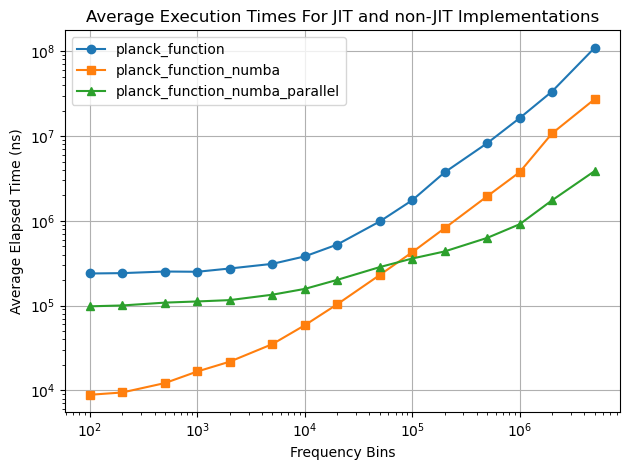

In [15]:
markers = (
    "o",
    "s",
    "^",
)
# Different markers to be color-blind friendly

for f, marker in zip(function_names, markers):
    plt.loglog(
        time_data_estimators.loc[f]["mean"],
        marker=marker,
        label=f,
    )
    # Semilog because of the range of values for freq_bin
plt.title("Average Execution Times For JIT and non-JIT Implementations")
plt.legend()
plt.grid()
plt.xlabel("Frequency Bins")
plt.ylabel("Average Elapsed Time (ns)")
plt.tight_layout()
plt.show()
# This plot is done in matplotlib because that's what's already used here
# and what's available currently installed. I could have done something
# more elaborate, but I didn't want to mess with the virtual environment.

We can clearly see where the benefits of parallelization overcome the overhead, i.e. where the square and triangle marked curves cross.